# Classifying the cards sets 

want to note that I only looking at the sets I found in the Default Cards data set (only in english). 

In [ ]:
#images are in the sets images folder


## preparing the data




In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import EfficientNetB0
import os
import shutil
from sklearn.model_selection import train_test_split

In [ ]:
!pwd


In [142]:
#split train/val data

original_dataset_dir = 'sets_images_cropped/'
train_dir = 'sets_train/'
val_dir = 'sets_val/'

# Create train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        
        if len(images) < 2:  # Skip classes with fewer than 2 images
            print(f"Skipping class {class_name} with less than 2 images.")
            continue
        
        # Split images into train and val sets
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
        
        # Create class subdirectories in train and val
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        
        # Move files to train directory
        for img in train_images:
            shutil.move(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )
        
        # Move files to val directory
        for img in val_images:
            shutil.move(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )

Skipping class astx with less than 2 images.
Skipping class amh2 with less than 2 images.


In [195]:
#constants

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 258

## preprocess the image 



In [196]:
#preparing the data set 

train_dir = 'sets_train/'
val_dir = 'sets_val/'

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_dataset = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_dataset = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 20617 images belonging to 258 classes.
Found 5411 images belonging to 258 classes.


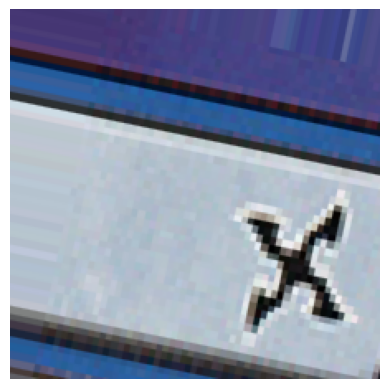

In [197]:
#view the image

import matplotlib.pyplot as plt

# Get a batch of images from the train dataset
images_batch, labels_batch = next(train_dataset)

# Select the first image in the batch (you can choose any other index)
image_to_view = images_batch[0]

# Display the image
plt.imshow(image_to_view)
plt.axis('off')  # Hide the axis for clarity
plt.show()

## load the model with a pretrained model - MobileNet



In [202]:
# Load Pretrained Model
base_model = MobileNetV3Large(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)

# First Dense Layer
x = Dense(1024, activation='relu')(x)  # Increased units for more complexity
x = Dropout(0.5)(x)  # Dropout layer for regularization

# Second Dense Layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer for regularization

# Third Dense Layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)  # Slightly lower dropout rate to keep more information

# Fourth Dense Layer (Optional)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Slightly lower dropout to help retain more learning

# Output Layer
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [203]:
# Train the Model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,          # Stop if no improvement after 5 epochs
    restore_best_weights=True  # Restore weights of the best epoch
)

EPOCHS = 300

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]  # Add the callback here
)

Epoch 1/300
645/645 [==============================] - 235s 350ms/step - loss: 5.5638 - accuracy: 0.0041 - val_loss: 5.5529 - val_accuracy: 0.0037
Epoch 2/300
645/645 [==============================] - 224s 347ms/step - loss: 5.5550 - accuracy: 0.0028 - val_loss: 5.5533 - val_accuracy: 0.0039
Epoch 3/300
645/645 [==============================] - 226s 350ms/step - loss: 5.5550 - accuracy: 0.0031 - val_loss: 5.5517 - val_accuracy: 7.3923e-04
Epoch 4/300
645/645 [==============================] - 223s 346ms/step - loss: 5.5430 - accuracy: 0.0046 - val_loss: 5.5265 - val_accuracy: 0.0067
Epoch 5/300
645/645 [==============================] - 231s 357ms/step - loss: 5.5070 - accuracy: 0.0063 - val_loss: 5.4926 - val_accuracy: 0.0063
Epoch 6/300
645/645 [==============================] - 254s 394ms/step - loss: 5.4149 - accuracy: 0.0076 - val_loss: 5.3270 - val_accuracy: 0.0116
Epoch 7/300
645/645 [==============================] - 259s 402ms/step - loss: 5.3258 - accuracy: 0.0089 - val_los

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

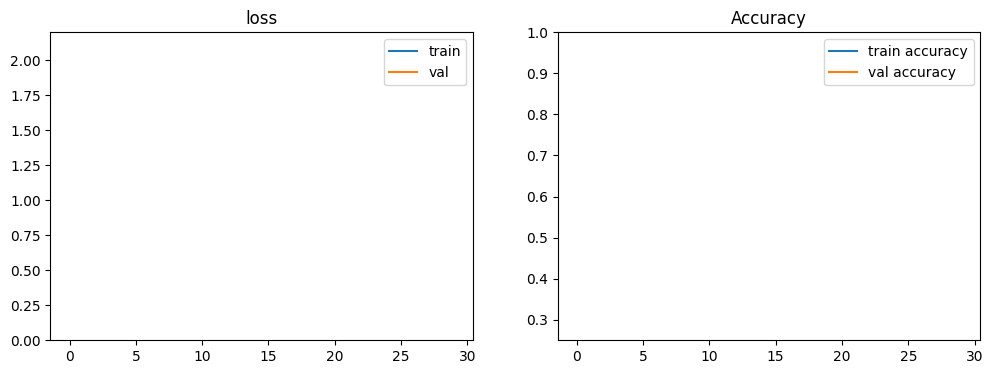

In [204]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)
plot_history(history)

In [15]:
predictions

array([[1.9368051e-02, 3.4726575e-02, 1.2394570e-01, 4.7272932e-02,
        7.8205708e-03, 6.0428218e-05, 6.4941063e-03, 3.9499678e-06,
        3.6576933e-01, 3.9453843e-01]], dtype=float32)

## attempting with my own model - we will use this one. 



In [181]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def initialize_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(258, activation = 'softmax'))
    
    return model

In [182]:
model = initialize_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 112, 112, 16)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 56, 56, 32)       

In [183]:
from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    return model

In [184]:
from tensorflow.keras.callbacks import EarlyStopping

model = compile_model(model)

# EarlyStopping callback
es = EarlyStopping(patience=15, verbose=2)

# Use train_dataset and val_dataset (ImageDataGenerator) instead of X_train_small and y_train_small
history_small = model.fit(
    train_dataset,  # Generator object for training data
    validation_data=val_dataset,  # Generator object for validation data
    epochs=100, 
    batch_size=32,  # Batch size, but this will be handled by the ImageDataGenerator
    callbacks=[es]  # EarlyStopping callback
)

Epoch 1/100
645/645 [==============================] - 239s 370ms/step - loss: 5.5722 - accuracy: 0.0024 - val_loss: 5.5529 - val_accuracy: 0.0039
Epoch 2/100
645/645 [==============================] - 233s 360ms/step - loss: 5.5542 - accuracy: 0.0025 - val_loss: 5.5529 - val_accuracy: 0.0039
Epoch 3/100
645/645 [==============================] - 235s 364ms/step - loss: 5.5542 - accuracy: 0.0025 - val_loss: 5.5528 - val_accuracy: 0.0039
Epoch 4/100
645/645 [==============================] - 232s 359ms/step - loss: 5.5542 - accuracy: 0.0031 - val_loss: 5.5528 - val_accuracy: 0.0039
Epoch 5/100
645/645 [==============================] - 243s 377ms/step - loss: 5.5541 - accuracy: 0.0020 - val_loss: 5.5528 - val_accuracy: 0.0039
Epoch 6/100
645/645 [==============================] - 248s 385ms/step - loss: 5.5545 - accuracy: 0.0033 - val_loss: 5.5528 - val_accuracy: 0.0039
Epoch 7/100
645/645 [==============================] - 259s 401ms/step - loss: 5.5541 - accuracy: 0.0024 - val_loss: 5

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

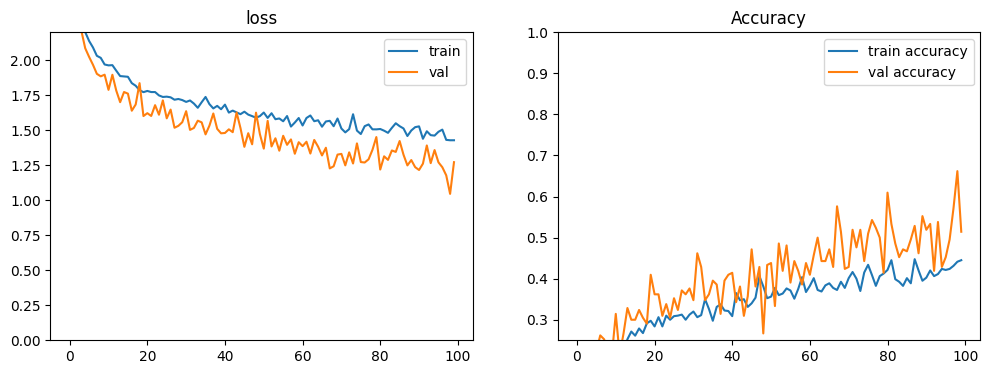

In [185]:
plot_history(history)


In [174]:
#saving the model 
model.save('model_small.h5')

In [171]:
img_path = 'bng-test-cropped.png'


In [172]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_card_set(img_path):
    # Preprocess the image
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    predictions = model.predict(img_array)

    # Get the top 3 predicted class indices and their probabilities
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_3_probabilities = predictions[0][top_3_indices]

    # Map the indices to class labels
    class_labels = {v: k for k, v in train_dataset.class_indices.items()}
    top_3_class_labels = [class_labels[index] for index in top_3_indices]

    return top_3_class_labels, top_3_probabilities


In [173]:
predict_card_set(img_path)

1/1 [==============================] - 0s 69ms/step


(['bok', 'bng', 'bro'],
 array([0.17330706, 0.16241598, 0.14020143], dtype=float32))

In [161]:
top_3_class_labels

['blc', 'blb', 'bng']

We will use this model as the accuracy is pretty high. 


# Creating a Filtering system using the name of the card 


In [48]:
import pandas as pd 
data = pd.read_json('default-cards.json')

In [81]:
#creating a function that would return the classes a name belongs to. 
def set_class_name(title):
    return data[data['name']==title]


In [134]:
set_class_name('Hold at Bay')['set']

103054    bng
Name: set, dtype: object

In [140]:
img_path = 'c14-test-cropped.png'

In [162]:
#matching the results from the prediction to the filter set_class_name
from IPython.display import Image


def matching_prediction_name(img_path, title):
    # Extract the relevant rows
    relevant_rows = set_class_name(title)

    # Create a list to store URLs for matched rows
    matched_image_urls = []

    for predicted_set in predict_card_set(img_path):
        # Filter rows where 'set' matches the predicted set exactly
        matching_rows = relevant_rows[relevant_rows['set'] == predicted_set]
        
        # Extract the image URL from the 'image_uris' column for each matched row
        for _, row in matching_rows.iterrows():
            if 'normal' in row['image_uris']:  # Ensure 'normal' key exists in the dictionary
                matched_image_urls.append(row['image_uris']['normal'])

    # Display all matched images
    for url in matched_image_urls:
        display(Image(url=url))

    return matched_image_urls 

In [165]:
matching_prediction_name(img_path,'Mystic Barrier')

1/1 [==============================] - 0s 82ms/step


['https://cards.scryfall.io/normal/front/f/f/ffb70bd4-e876-4242-b5b4-bb7493710f0f.jpg?1562949148']